<a href="https://colab.research.google.com/github/Bigmee/flower-Recognition-models-/blob/main/deep_learning_project_Flowers_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Identitfying Flower species using Deep Learning and PyTorch

Deep learning is a subset of machine learning that uses algorithms inspired by the structure and function of the brain's neural networks to learn from large amounts of data. It is used to solve complex problems such as image recognition, natural language processing, and autonomous driving.

My dataset  (Flowers Recognition) was gotten from Kaggle 
link: 'https://www.kaggle.com/datasets/alxmamaev/flowers-recognition'

it contains 4317 samples of flowers divided in 5 classes five classes namely: daisy', 'dandelion', 'rose', 'sunflower', 'tulip'.

This project went through the following steps below

1. Picking a dataset from Kaggle
2.  Downloading the Datasets
3. importing the Dataset using PyTorch
4. Preparing the Dataset for training 
5. Moving the Dataset to GPU
6. Defining a neural network
7. Training th Model
8. Making predition on sample images and iterating it with different networks and hyperparameters 


project by **Eze Chukwuemeka Joseph ** 
**chukwuemeka.j.eze@gmail.com**




In [ ]:
pip install opendatasets


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import opendatasets as od

In [ ]:
dataset_url = 'https://www.kaggle.com/datasets/alxmamaev/flowers-recognition'

In [ ]:
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: chukwuemekaeze123
Your Kaggle Key: ··········


100%|██████████| 225M/225M [00:02<00:00, 93.2MB/s]


# Checking the directory

In [ ]:
data_dir = './flowers-recognition/flowers'

In [ ]:
import os

In [ ]:
os.listdir(data_dir)

['dandelion', 'tulip', 'daisy', 'sunflower', 'rose']

# import the dataset into pytorch 
then use the image folder class for torchvision

In [ ]:
from torchvision.datasets import ImageFolder

In [ ]:
datasets = ImageFolder(data_dir)

In [ ]:
#checking the lenght of the dataset
len(datasets)

4317

In [ ]:
datasets[0]

(<PIL.Image.Image image mode=RGB size=320x263 at 0x7F577A1EC2B0>, 0)

In [ ]:
datasets.classes

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

## finding out the class compositions

In [ ]:
for cls in os.listdir(data_dir):
    print(cls, ':', len(os.listdir(data_dir + '/' + cls)))

dandelion : 1052
tulip : 984
daisy : 764
sunflower : 733
rose : 784


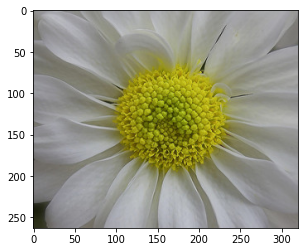

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
img, label = datasets[0]
plt.imshow(img)

In [ ]:
import torchvision.transforms as tt
dataset = ImageFolder(data_dir, tt.Compose([tt.Resize(64),
                                            tt.RandomCrop(64),
                                            tt.ToTensor()]))

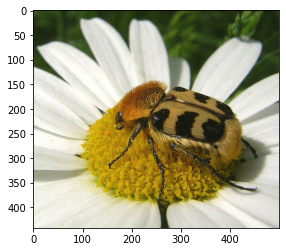

In [ ]:
img, label = datasets[120]
plt.imshow(img)

In [ ]:
val_pct = 0.1 
val_size = int(val_pct * len(dataset))
train_size = len(dataset) - val_size

train_size, val_size

(3886, 431)

In [ ]:
from torch.utils.data import random_split

train_ds, valid_ds = random_split(dataset, [train_size, val_size])

In [ ]:
len(train_ds), len(valid_ds)

(3886, 431)

In [ ]:
#creating data loaders to load the data in batches



In [ ]:
from torch.utils.data import DataLoader

batch_size = 128

train_dl = DataLoader(train_ds, 
                      batch_size, 
                      shuffle=True, 
                      num_workers=4, 
                      pin_memory=True)

valid_dl = DataLoader(valid_ds, 
                    batch_size, 
                    num_workers=4, 
                    pin_memory=True)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

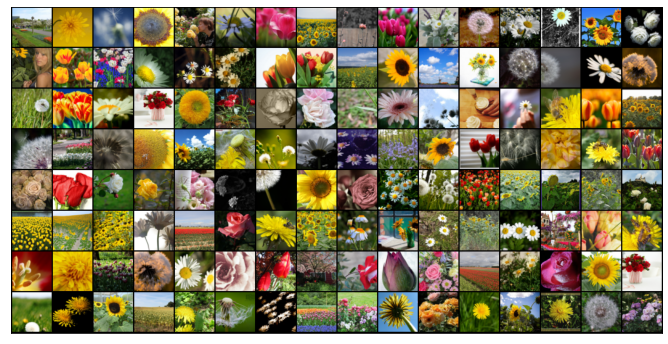

In [ ]:
show_batch(train_dl)

# 

### GPU Utilities

In [ ]:
import torch

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)


In [ ]:
torch.cuda.is_available()

True

In [ ]:
device = get_default_device()

In [ ]:
device

device(type='cuda')

In [ ]:
img, label = dataset[0]

In [ ]:
img.device

device(type='cpu')

In [ ]:
img_gpu = to_device(img, device)
img_gpu.device

device(type='cuda', index=0)

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

# Model and Training 


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        "calculate loss for a batch of training data"
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        "calculate loss & accuracy for a batch of validation data"
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    """Evaluates the model's performance on the validation set"""
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        # Input: 128 x 3 x 64 x 64
        self.conv1 = conv_block(in_channels, 64) # 128 x 64 x 64 x 64
        self.conv2 = conv_block(64, 128, pool=True) # 128 x 128 x 32 x 32
        self.res1 = nn.Sequential(conv_block(128, 128), # 128 x 128 x 32 x 32
                                  conv_block(128, 128)) # 128 x 128 x 32 x 32
        
        self.conv3 = conv_block(128, 256, pool=True) # 128 x 256 x 16 x 16
        self.conv4 = conv_block(256, 512, pool=True) # 128 x 512 x 8 x 8 
        self.res2 = nn.Sequential(conv_block(512, 512), # 128 x 512 x 8 x 8 
                                  conv_block(512, 512)) # 128 x 512 x 8 x 8 
        
        self.classifier = nn.Sequential(nn.AdaptiveMaxPool2d(1), # 128 x 512 x 1 x 1 
                                        nn.Flatten(), # 128 x 512
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

# Models

ResNet9 Model

In [ ]:
model = to_device(ResNet9(3, len(dataset.classes)), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [ ]:
model.conv1[0].weight.device

device(type='cuda', index=0)

passing one batch of input tensor through the model, to see if everything is set up properly

In [ ]:
for batch in train_dl:
    images, labels = batch
    print ('images.shape', images.shape)
    print('images.device', images.device)
    preds = model(images)
    print('preds.shape', preds.shape)
    #print(preds)
    break

images.shape torch.Size([128, 3, 64, 64])
images.device cuda:0
preds.shape torch.Size([128, 5])


# Training

In [ ]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 1.6128461360931396, 'val_acc': 0.16526761651039124}]

In [ ]:
history += fit(5, 0.001, model, train_dl, valid_dl, torch.optim.Adam)

Epoch [0], train_loss: 1.5014, val_loss: 1.2420, val_acc: 0.4881
Epoch [1], train_loss: 0.9606, val_loss: 0.9492, val_acc: 0.6395
Epoch [2], train_loss: 0.8397, val_loss: 0.7621, val_acc: 0.7163
Epoch [3], train_loss: 0.7724, val_loss: 0.7041, val_acc: 0.7316
Epoch [4], train_loss: 0.6755, val_loss: 0.7306, val_acc: 0.7244


In [ ]:
history += fit(5, 0.0001, model, train_dl, valid_dl, torch.optim.Adam)

Epoch [0], train_loss: 0.5899, val_loss: 0.5313, val_acc: 0.7978
Epoch [1], train_loss: 0.5290, val_loss: 0.4768, val_acc: 0.8328
Epoch [2], train_loss: 0.5130, val_loss: 0.4760, val_acc: 0.8168
Epoch [3], train_loss: 0.4661, val_loss: 0.4863, val_acc: 0.8143
Epoch [4], train_loss: 0.4411, val_loss: 0.4249, val_acc: 0.8367


In [ ]:
history += fit(5, 0.00001, model, train_dl, valid_dl, torch.optim.Adam)

Epoch [0], train_loss: 0.3901, val_loss: 0.4251, val_acc: 0.8504
Epoch [1], train_loss: 0.3873, val_loss: 0.4290, val_acc: 0.8523
Epoch [2], train_loss: 0.3871, val_loss: 0.4200, val_acc: 0.8509
Epoch [3], train_loss: 0.3648, val_loss: 0.4184, val_acc: 0.8378
Epoch [4], train_loss: 0.3716, val_loss: 0.4268, val_acc: 0.8425


In [ ]:
history += fit(5, 0.000001, model, train_dl, valid_dl, torch.optim.Adam)

Epoch [0], train_loss: 0.3728, val_loss: 0.4002, val_acc: 0.8509
Epoch [1], train_loss: 0.3677, val_loss: 0.4223, val_acc: 0.8504
Epoch [2], train_loss: 0.3684, val_loss: 0.4175, val_acc: 0.8484
Epoch [3], train_loss: 0.3577, val_loss: 0.4215, val_acc: 0.8445
Epoch [4], train_loss: 0.3797, val_loss: 0.4109, val_acc: 0.8543


# Data Visualisation

plotting the accuracy

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

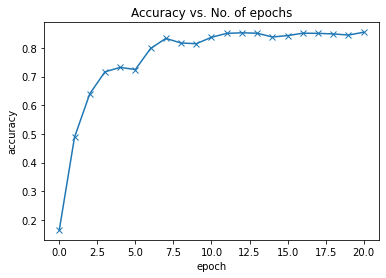

In [ ]:
plot_accuracies(history)

plotting the losses

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

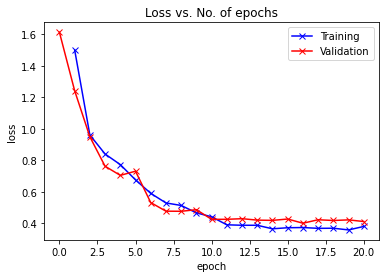

In [ ]:
plot_losses(history)

In [ ]:
!pip install jovian --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.6/68.6 KB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
!pip install jovian --quiet

In [ ]:
import jovian

# Record the Results

In [ ]:
history[-1]

{'val_loss': 0.4108617305755615,
 'val_acc': 0.8542636632919312,
 'train_loss': 0.379712849855423}

In [ ]:
jovian.reset()
jovian.log_dataset(image_size=64)
jovian.log_hyperparams(batch_size=128, 
                       arch='ResNet9', 
                       epochs=[5, 5, 5, 5], 
                       lrs=[0.001, 0.001, 1e-4, 1e-4],
                       opt=['Adam', 'Adam', 'Adam', 'SGD'])
jovian.log_metrics(train_loss=history[-1]['train_loss'],
                   val_acc=history[-1]['val_acc'],
                   val_loss=history[-1]['val_loss'])

[jovian] Please enter your API key ( from https://jovian.ai/ ):
API KEY: ··········
[jovian] Dataset logged.
[jovian] Hyperparams logged.
[jovian] Metrics logged.


# Test with Individual Images

In [ ]:
def predict_image(img, model, classes):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return classes[preds[0].item()]

In [ ]:
def show_image_prediction(img, label):
    plt.imshow(img.permute((1, 2, 0)))
    pred = predict_image(img, model, dataset.classes)
    print('Target:', dataset.classes[label])
    print('Prediction:', pred)

Target: sunflower
Prediction: daisy


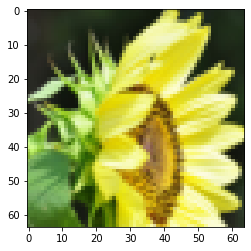

In [ ]:
show_image_prediction(*valid_ds[100])

Target: tulip
Prediction: tulip


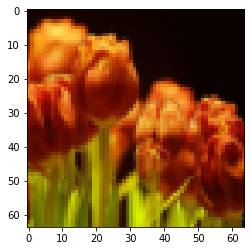

In [ ]:
show_image_prediction(*valid_ds[300])

Target: daisy
Prediction: daisy


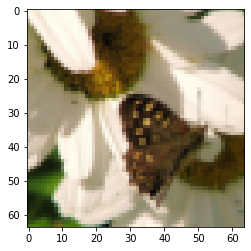

In [ ]:
show_image_prediction(*valid_ds[12])

Target: dandelion
Prediction: dandelion


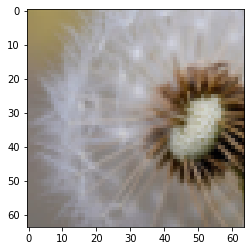

In [ ]:
show_image_prediction(*valid_ds[19])

In [ ]:
torch.save(model.state_dict(), 'flowers-resnet9.pth')

In [ ]:
jovian

<module 'jovian' from '/usr/local/lib/python3.8/dist-packages/jovian/__init__.py'>